## **Classification Animal Images using Pytorch :**
### **Importing the data :**

In [1]:
import opendatasets as od 
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:01<00:00, 634MB/s] 


In [59]:
import torch 
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import  Dataset , DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt 
from PIL import  Image 
import pandas as pd 
import numpy as np 
import os
import seaborn as sns
device =  "cuda" if torch.cuda.is_available() else "cpu"
print('the device available is :',device)

the device available is : cuda


In [45]:
image_path = []
labels = []

base_path = r"animal-faces\afhq"

for file in os.listdir(base_path):
    folder_path = os.path.join(base_path,file)
    for label in os.listdir(folder_path):
        for image in os.listdir(os.path.join(folder_path,label)):
            image_path.append(os.path.join(folder_path,label,image))
            labels.append(label)
data = pd.DataFrame(zip(image_path,labels),columns=["image_path","labels"])
data.head()



,image_path,labels
0,animal-faces\afhq\train\cat\flickr_cat_000002.jpg,cat
1,animal-faces\afhq\train\cat\flickr_cat_000003.jpg,cat
2,animal-faces\afhq\train\cat\flickr_cat_000004.jpg,cat
3,animal-faces\afhq\train\cat\flickr_cat_000005.jpg,cat
4,animal-faces\afhq\train\cat\flickr_cat_000006.jpg,cat


<Axes: xlabel='labels', ylabel='count'>

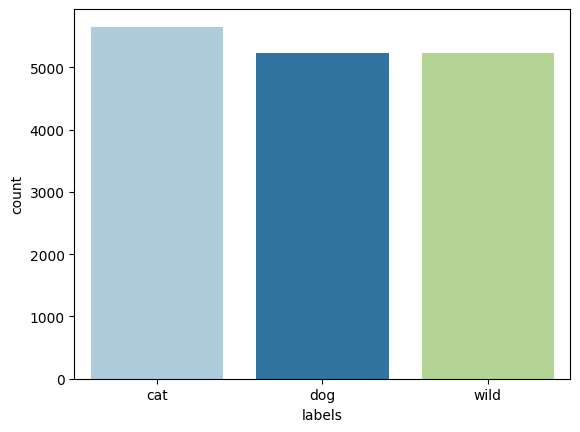

In [51]:
sns.countplot(x=data['labels'],hue=data['labels'],palette="Paired")

### **splitting the data** 

In [53]:

train = data.sample(frac=0.7)
test_data = data.drop(train.index)
val =  test_data.sample(frac=0.5)
test = test_data.drop(val.index)

print('train size ', train.shape)
print('test size ', test.shape)
print('evaluation size ', val.shape)


train size  (11291, 2)
test size  (2419, 2)
evaluation size  (2420, 2)


### **Data preprocessing**

In [95]:
encoder = LabelEncoder()
encoder = encoder.fit(data["labels"])

transform = transforms.Compose([
    transforms.Resize((128,128)), # resizing the images
    transforms.ToTensor(), # transforming them to tensors
    transforms.ConvertImageDtype(torch.float) # Converting the image to float
])


#### **building a Custom data class to preprocess the data** 

In [ ]:

class Custom_data(Dataset):
    def __init__(self,dataframe,transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(encoder.transform(dataframe['labels'])).to(device)
    def __len__(self):
        return self.dataframe.shape[0]
    def __getitem__(self,idx):
        img_path = self.dataframe.iloc[idx,0]
        labels = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image).to(device)
        return image , labels


In [107]:
train_data = Custom_data(dataframe=train,transform=transform)
test_data = Custom_data(dataframe=test,transform=transform)
val_data = Custom_data(dataframe=val,transform=transform)        

In [109]:
train_data.__getitem__(2)

(tensor([[[0.3765, 0.3765, 0.3804,  ..., 0.4314, 0.4078, 0.4431],
          [0.3765, 0.3765, 0.3804,  ..., 0.4118, 0.3843, 0.3686],
          [0.3725, 0.3804, 0.3804,  ..., 0.4235, 0.2588, 0.1647],
          ...,
          [0.3843, 0.3882, 0.3961,  ..., 0.5569, 0.5686, 0.5725],
          [0.3843, 0.3882, 0.3961,  ..., 0.5608, 0.5529, 0.5804],
          [0.3922, 0.3882, 0.3922,  ..., 0.5451, 0.5569, 0.5804]],
 
         [[0.2941, 0.2941, 0.2980,  ..., 0.1608, 0.1961, 0.2824],
          [0.2941, 0.2941, 0.2980,  ..., 0.1843, 0.2235, 0.2745],
          [0.2902, 0.2980, 0.2980,  ..., 0.2588, 0.1647, 0.1333],
          ...,
          [0.3882, 0.3922, 0.4000,  ..., 0.5412, 0.5647, 0.5686],
          [0.3882, 0.3961, 0.4000,  ..., 0.5451, 0.5490, 0.5765],
          [0.4000, 0.3961, 0.4000,  ..., 0.5294, 0.5529, 0.5765]],
 
         [[0.0392, 0.0392, 0.0431,  ..., 0.1020, 0.1255, 0.2000],
          [0.0392, 0.0392, 0.0431,  ..., 0.1176, 0.1804, 0.2392],
          [0.0353, 0.0431, 0.0431,  ...,

In [ ]:
encoder.inverse_transform([2])
# 0 is cat
# 1 is the dog
# 2 is wild

array(['wild'], dtype=object)

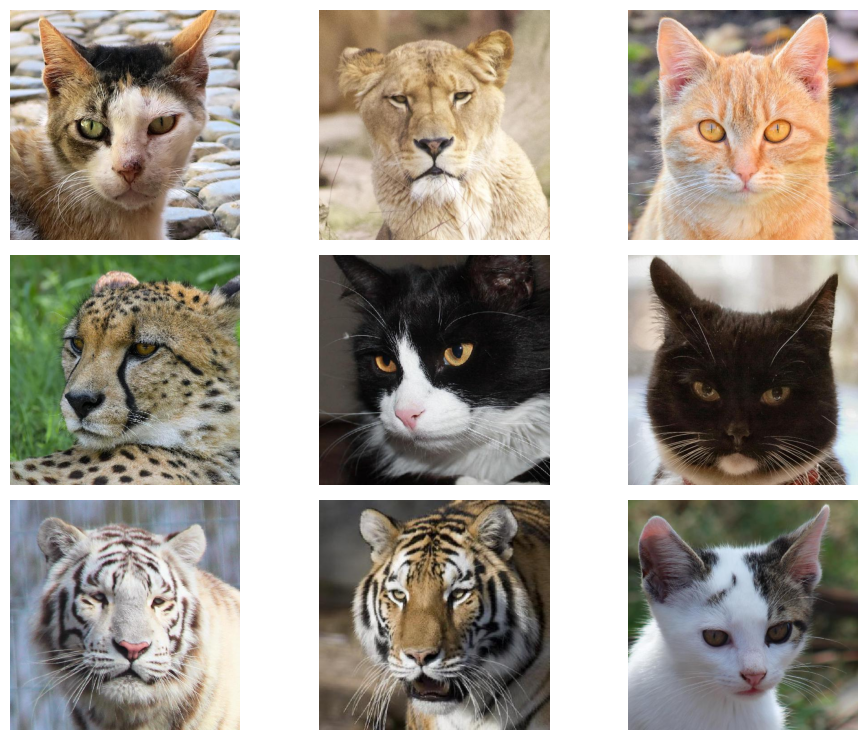

In [148]:
n_row = 3
n_col = 3

f , ax = plt.subplots(n_row ,n_col ,figsize=(10,7.5))
ax = ax.flatten()
for i in range(len(ax)):
    image = Image.open(data.sample(n=1)['image_path'].iloc[0]).convert('RGB')
    ax[i].imshow(image)
    ax[i].axis('off')
plt.tight_layout()    

In [150]:
LR = 1e-4
b_s = 16
epochs = 10

#### **loading the data**

In [151]:
train_loader = DataLoader(train_data,batch_size=b_s,shuffle=True)
test_loader = DataLoader(test_data,batch_size=b_s,shuffle=True)
val_loader = DataLoader(val_data,batch_size=b_s,shuffle=True)

#### **building our model**

In [172]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # convolution layer
        self.conv_1 = nn.Conv2d(3,32,kernel_size=3,padding=1)
        self.conv_2 = nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.conv_3 = nn.Conv2d(64,128,kernel_size=3,padding=1)
        # pooling layer
        self.pooling = nn.MaxPool2d(2,2)
        # activation function
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear((128*16*16),128)
        self.output = nn.Linear(128,len(data['labels'].unique()))
    def forward(self,x):
        x = self.conv_1(x) # -> (32,128,128)
        x = self.pooling(x) # -> (32,64,64)
        x = self.relu(x) 

        x = self.conv_2(x) # -> (64,64,64)
        x = self.pooling(x) # -> (64,32,32)
        x = self.relu(x) 

        x = self.conv_3(x) # -> (64,32,32)
        x = self.pooling(x) # -> (128,16,16)
        x = self.relu(x) 

        x = self.flatten(x)
        x = self.linear(x)
        x = self.output(x)

        return x

model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(),lr=LR)

In [171]:
from torchsummary import summary

summary(model,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [189]:
from tqdm import tqdm

In [ ]:
loss_train = []
loss_val = []
acc_train = []
acc_val = []

#training loop 
for ep in tqdm(range(epochs)) :
    total_loss_train = 0
    total_loss_val = 0
    total_acc_train = 0
    total_acc_val = 0
    for input , label in train_loader :
        input, label = input.to(device), label.to(device)

        optimizer.zero_grad()
        output = model(input)

        train_loss = criterion(output,label.long())
        total_loss_train += train_loss.item()
        train_loss.backward()
        train_acc = (torch.argmax(output,axis=1) == label).sum().item()
        total_acc_train += train_acc

        optimizer.step()
    # evaluation Loop
    with torch.inference_mode():
        for input , label in val_loader :
            input, label = input.to(device), label.to(device)
            output = model(input)
            #loss 
            val_loss = criterion(output,label.long()).item()
            total_loss_val += val_loss
            # accuracy
            val_acc = (torch.argmax(output,axis=1) == label).sum().item()
            total_acc_val += val_acc
        # appending the total loss            
        loss_train.append(round(total_loss_train/1000,4))
        loss_val.append(round(total_acc_val/1000,4))
        # appending the total accuracy
        acc_train.append(round((total_acc_train/train_data.__len__()*100),4))
        acc_val.append(round((total_acc_val/val_data.__len__()*100),4))

# getting status of the model loss and accuracy evolution

    print(f''' epoch : {ep} | trainig loss : {round(total_loss_train/1000,4)} | evaluation loss : {round(total_acc_val/1000,4)} | training accuracy : {round((total_acc_train/train_data.__len__()*100),4)} | testing accuracy : {round((total_acc_val/val_data.__len__()*100),4)} ''')
    print('='*100)


 epoch : 0 | trainig loss : 0.2165 | evaluation loss : 2.199 | training accuracy : 88.6458 | testing accuracy : 90.8678 


 epoch : 1 | trainig loss : 0.1174 | evaluation loss : 2.266 | training accuracy : 94.1635 | testing accuracy : 93.6364 


 epoch : 2 | trainig loss : 0.0833 | evaluation loss : 2.316 | training accuracy : 95.6868 | testing accuracy : 95.7025 


 epoch : 3 | trainig loss : 0.0611 | evaluation loss : 2.277 | training accuracy : 96.9799 | testing accuracy : 94.0909 


 40%|████      | 4/10 [10:11<15:17, 152.88s/it]


KeyboardInterrupt: 